<a href="https://colab.research.google.com/github/mdsiam135/research/blob/main/xgboast_5label.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
pip install --upgrade xgboost


In [8]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
# Load datasets
train = pd.read_csv('/content/drive/MyDrive/Dataset_for_Train_Validation_Test/train.csv')
val = pd.read_csv('/content/drive/MyDrive/Dataset_for_Train_Validation_Test/validation.csv')
test = pd.read_csv('/content/drive/MyDrive/Dataset_for_Train_Validation_Test/test.csv')


In [10]:
# Bin 'Production (M.Ton)' into 5 classes
combined = pd.concat([train, val])
y_combined = combined['Production (M.Ton)'].values.reshape(-1, 1)

binner = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
binner.fit(y_combined)

train['Production_Class'] = binner.transform(train[['Production (M.Ton)']]).astype(int)
val['Production_Class'] = binner.transform(val[['Production (M.Ton)']]).astype(int)
test_y_binned = binner.transform(test[['Production (M.Ton)']]).astype(int) if 'Production (M.Ton)' in test else None

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but KBinsDiscretizer was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but KBinsDiscretizer was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but KBinsDiscretizer was fitted without feature names
  warnings.warn(


In [11]:
# Prepare features and labels
X_train = train.drop(columns=['Production (M.Ton)', 'Production_Class'])
y_train = train['Production_Class']
X_val = val.drop(columns=['Production (M.Ton)', 'Production_Class'])
y_val = val['Production_Class']
X_test = test.drop(columns=['Production (M.Ton)'], errors='ignore')

In [12]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


In [13]:
# Train XGBoost model
model = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=5,
    eval_metric='mlogloss',
    learning_rate=0.1,
    n_estimators=100,
    use_label_encoder=False
)

eval_set = [(X_train_scaled, y_train), (X_val_scaled, y_val)]
model.fit(X_train_scaled, y_train, eval_set=eval_set, verbose=True)

[0]	validation_0-mlogloss:1.47446	validation_1-mlogloss:1.48477
[1]	validation_0-mlogloss:1.36299	validation_1-mlogloss:1.38117
[2]	validation_0-mlogloss:1.26783	validation_1-mlogloss:1.29096
[3]	validation_0-mlogloss:1.18452	validation_1-mlogloss:1.21350
[4]	validation_0-mlogloss:1.11295	validation_1-mlogloss:1.14806
[5]	validation_0-mlogloss:1.04974	validation_1-mlogloss:1.08979


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:02:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  msg += " or "


[6]	validation_0-mlogloss:0.99530	validation_1-mlogloss:1.04007
[7]	validation_0-mlogloss:0.94660	validation_1-mlogloss:0.99567
[8]	validation_0-mlogloss:0.90344	validation_1-mlogloss:0.95528
[9]	validation_0-mlogloss:0.86387	validation_1-mlogloss:0.91968
[10]	validation_0-mlogloss:0.82762	validation_1-mlogloss:0.88688
[11]	validation_0-mlogloss:0.79560	validation_1-mlogloss:0.85761
[12]	validation_0-mlogloss:0.76577	validation_1-mlogloss:0.82982
[13]	validation_0-mlogloss:0.73894	validation_1-mlogloss:0.80546
[14]	validation_0-mlogloss:0.71453	validation_1-mlogloss:0.78354
[15]	validation_0-mlogloss:0.69266	validation_1-mlogloss:0.76457
[16]	validation_0-mlogloss:0.67282	validation_1-mlogloss:0.74709
[17]	validation_0-mlogloss:0.65404	validation_1-mlogloss:0.73105
[18]	validation_0-mlogloss:0.63639	validation_1-mlogloss:0.71594
[19]	validation_0-mlogloss:0.61970	validation_1-mlogloss:0.70207
[20]	validation_0-mlogloss:0.60492	validation_1-mlogloss:0.68940
[21]	validation_0-mlogloss:0.

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_class=5, num_parallel_tree=None, ...)

In [14]:
# Evaluation function
def evaluate(name, y_true, y_pred):
    print(f"📊 {name} Classification Report")
    print(classification_report(y_true, y_pred, target_names=['Very Low', 'Low', 'Medium', 'High', 'Very High']))
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
    disp.plot(cmap='Blues')
    plt.title(f"{name} Confusion Matrix")
    plt.show()

📊 Validation Classification Report
              precision    recall  f1-score   support

    Very Low       0.97      0.88      0.92       160
         Low       0.80      0.82      0.81       147
      Medium       0.73      0.79      0.76       153
        High       0.75      0.73      0.74       156
   Very High       0.85      0.87      0.86       152

    accuracy                           0.82       768
   macro avg       0.82      0.82      0.82       768
weighted avg       0.82      0.82      0.82       768



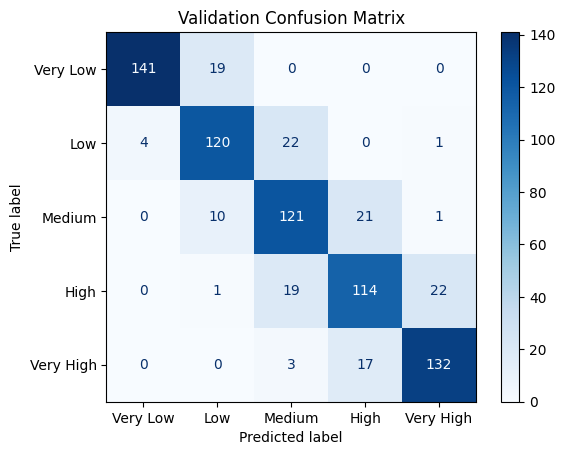

In [15]:
# Evaluate on validation
val_preds = model.predict(X_val_scaled)
evaluate("Validation", y_val, val_preds)


📊 Test Classification Report
              precision    recall  f1-score   support

    Very Low       0.95      0.93      0.94       149
         Low       0.82      0.81      0.81       153
      Medium       0.75      0.81      0.78       163
        High       0.76      0.76      0.76       136
   Very High       0.94      0.89      0.91       167

    accuracy                           0.84       768
   macro avg       0.84      0.84      0.84       768
weighted avg       0.85      0.84      0.84       768



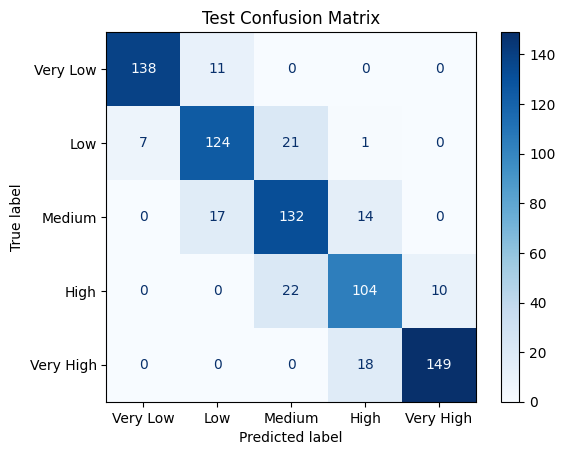

In [16]:
# Evaluate on test (if labels available)
if test_y_binned is not None:
    test_preds = model.predict(X_test_scaled)
    evaluate("Test", test_y_binned.ravel(), test_preds)

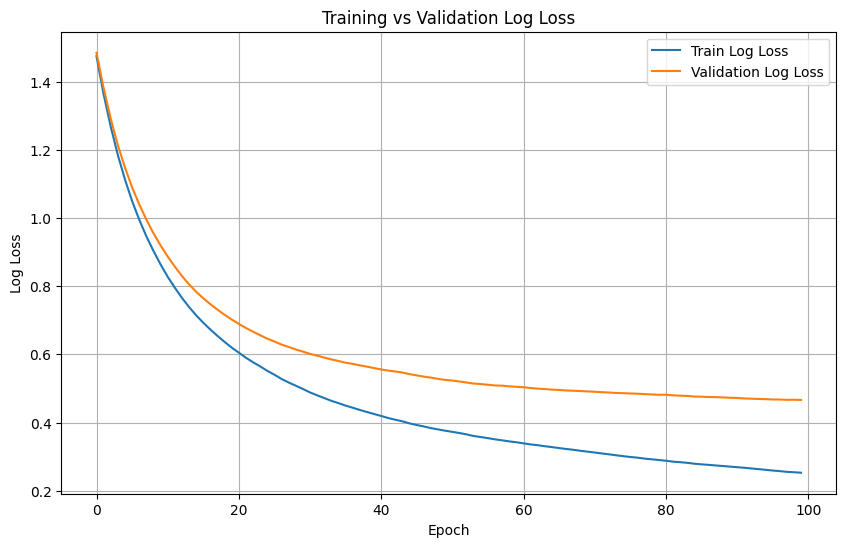

In [17]:
# Plot training vs validation log loss
results = model.evals_result()
epochs = len(results['validation_0']['mlogloss'])

plt.figure(figsize=(10, 6))
plt.plot(range(epochs), results['validation_0']['mlogloss'], label='Train Log Loss')
plt.plot(range(epochs), results['validation_1']['mlogloss'], label='Validation Log Loss')
plt.xlabel('Epoch')
plt.ylabel('Log Loss')
plt.title('Training vs Validation Log Loss')
plt.legend()
plt.grid(True)
plt.show()